In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import json
import os
import random

import numpy as np
import torch
import scipy.io

from experiment import lesion
from experiment import mRNN
from experiment import michaels_load
from experiment import config, experiment, utils
import cpn_model
import stim_model

#CUDA = torch.device(0)
CUDA = None

MODEL_PATHS = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.2.175_enActTanh_cpnActTanh/c7583779-4622-40a6-a259-59f2e8c0cfd9"

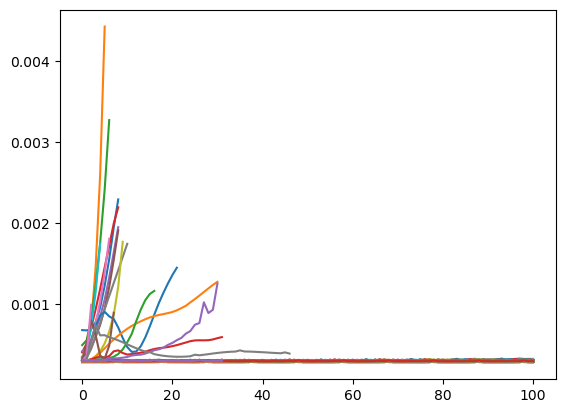

In [2]:
log_path = os.path.join(MODEL_PATHS, "log")

log = json.load(open(log_path, "r"))

pred_losses = []
pred_val_losses = []
cur_type = "EN"
cur = []
cur_val = []
for r in log:
    next_type = r['user']['epoch_type']
    
    if next_type == "EN" and cur_type == "CPN":
        pred_losses.append(cur)
        cur = []
        
        pred_val_losses.append(cur_val)
        cur_val = []
    if next_type == "CPN":
        cur.append(float(r['user']['pred_loss']))
        cur_val.append(float(r['user']['pred_val_loss']))

    cur_type = next_type

for t in pred_losses:
    #cur = []
    #ll = len(t)
    #for sidx in range(ll):
    #    curx = sidx / ll
        
    plt.plot(t)

In [3]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(),
    cuda=CUDA, with_label=True)

# Dataset items are:
#   (michaels network input, trial end indicator, trial len (scalar),
#    target output, class label)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
batch = next(iter(dataloader))

In [4]:
PATH_MRNN = os.path.join(MODEL_PATHS, "mike.model")
PATH_CPN = os.path.join(MODEL_PATHS, "cpn.model")
PATH_EN = os.path.join(MODEL_PATHS, "en.model")

cfg = experiment.get_vanilla_config(coadapt=False, cuda=CUDA)
in_dim, stim_dim, out_dim, _ = cfg.unpack()
observer = cfg.observer_instance

In [5]:
mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                        stimulus=cfg.stim_instance,
                        cuda=CUDA)

mike.load_state_dict(torch.load(PATH_MRNN, map_location=torch.device('cpu')))

mike.set_lesion(cfg.lesion_instance)

In [6]:
en_in_dim = cfg.observer_instance.out_dim + stim_dim + 1

en, _ = stim_model.get_stim_model(
  en_in_dim, out_dim, activation=cfg.en_activation, cuda=CUDA
)

en.load_state_dict(torch.load(PATH_EN, map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
cpn = cpn_model.CPNModelLSTM(                                    
            in_dim,                                            
            stim_dim,
            num_neurons=in_dim,                     
            activation_func=cfg.cpn_activation,
            cuda=CUDA)
cpn.load_state_dict(torch.load(PATH_CPN, map_location=torch.device('cpu')))

<All keys matched successfully>

In [8]:
# Run experiment forward, and get EN results too.

din, trial_end, _, dout, labels = batch
steps = din.shape[1]

actuals = []
preds = []

mike_out = mike(din[:, 0, :].T)

for tidx in range(steps - 1):
    obs_raw = mike.observe(observer)
    obs = obs_raw + (trial_end[:, tidx, :],)
    cpn_in = torch.cat(obs, axis=1)

    stim = cpn(cpn_in)

    # new_stim will be cloned in here, to prevent accidentally
    # backprop-ing through the "brain", aka mike.
    mike.stimulate(stim)

    mike_out = mike(din[:, tidx + 1, :].T)
    actuals.append(mike_out.unsqueeze(dim=1))
    
    # Now let's get the EN output too.
    en_in = torch.cat((obs[0], stim, obs[-1]), axis=1)
    pred = en(en_in)
    preds.append(pred.unsqueeze(dim=1))
    
actuals = torch.cat(actuals, axis=1)
actuals = utils.trunc_to_trial_end(actuals, trial_end[:, :-1, :])

preds = torch.cat(preds, axis=1)
preds = utils.trunc_to_trial_end(preds, trial_end[:, :-1, :])

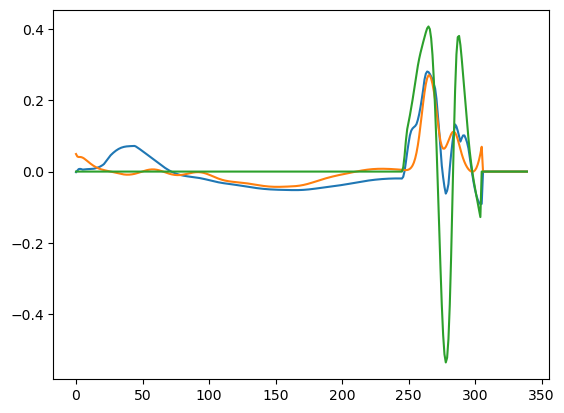

In [9]:
cidx = random.randrange(preds.shape[-1])
ridx = random.randrange(preds.shape[0])

plt.plot(actuals[ridx, :, cidx].detach().numpy())
plt.plot(preds[ridx, :, cidx].detach().numpy())
plt.plot(dout[ridx, 1:, cidx].detach().numpy())

196 8.411065937252715e-05 417 0.00034606328699737787 0 1
std: 1.91e-05


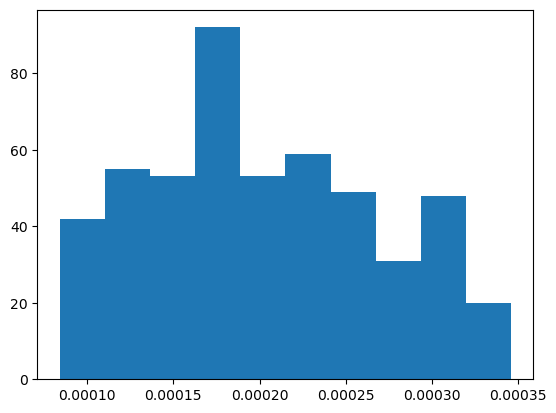

In [41]:
cidx = 7  # TMAJ_l from the graphs earlier; a hand muscle

pred_losses = []

max_loss = -11111
min_loss = 1111111
ridx_min = None
ridx_max = None
for ridx in range(preds.shape[0]):
    cur_loss = torch.nn.MSELoss()(preds[ridx, :, cidx], actuals[ridx, :, cidx]).detach().numpy().item()
    pred_losses.append(cur_loss)
    
    if cur_loss > max_loss:
        max_loss = cur_loss
        ridx_max = ridx
    if cur_loss < min_loss:
        min_loss = cur_loss
        ridx_min = ridx
        
ridx_other1 = None
other1_loss = None
ridx_other2 = None
other2_loss = None
losses = torch.zeros(preds.shape[0])
for ridx in range(preds.shape[0]):
    if ridx != ridx_min and ridx != ridx_max:
        cur_loss = torch.nn.MSELoss()(preds[ridx, :, cidx], actuals[ridx, :, cidx]).detach().numpy().item()
        losses[ridx] = cur_loss
        if ridx_other1 is None:
            ridx_other1 = ridx
            other1_loss = cur_loss
        else:
            ridx_other2 = ridx
            other2_loss = cur_loss
            break
            
if other1_loss > other2_loss:
    blahR, blahL = ridx_other1, other1_loss
    ridx_other1, other1_loss = ridx_other2, other2_loss
    ridx_other2, other2_loss = blahR, blahL

print(ridx_min, min_loss, ridx_max, max_loss, ridx_other1, ridx_other2)

tmaj_std = torch.std(losses).item()
print(f"std: {tmaj_std:.2e}")

plt.hist(pred_losses)
plt.show()

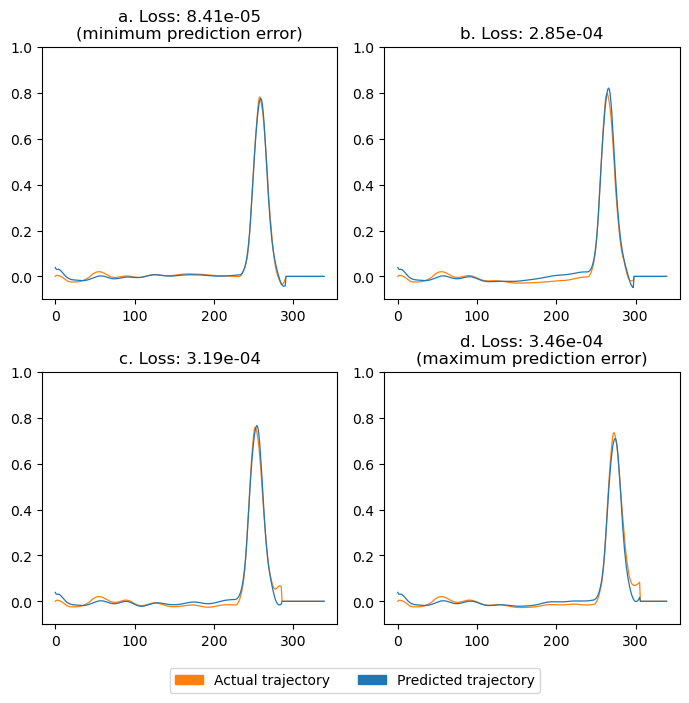

In [60]:
cidx = 7  # TMAJ_l from the graphs earlier; a hand muscle
linewidth = 0.9
tx = 0.1
ty = 0.88

fig,axs = plt.subplots(2,2, figsize=(7, 7))

axs[0,0].plot(actuals[ridx_min, :, cidx].detach().numpy(), linewidth=linewidth, color='tab:orange', label="Actual trajectory")
axs[0,0].plot(preds[ridx_min, :, cidx].detach().numpy(), linewidth=linewidth, color='tab:blue', label="Predicted trajectory")
#axs[0,0].plot(dout[ridx_min, 1:, cidx].detach().numpy(), linewidth=linewidth, color='tab:purple', label="Target trajectory")
axs[0,0].set_title(f"a. Loss: {min_loss:.2e}\n(minimum prediction error)")
axs[0,0].set_ylim(-0.1, 1.0)
#axs[0,0].text(tx, ty, "a.", fontsize='x-large', fontfamily='serif')

axs[0,1].plot(actuals[ridx_other1, :, cidx].detach().numpy(), linewidth=linewidth, color='tab:orange', label="Actual trajectory")
axs[0,1].plot(preds[ridx_other1, :, cidx].detach().numpy(), linewidth=linewidth, color='tab:blue', label="Predicted trajectory")
#axs[0,1].plot(dout[ridx_other1, 1:, cidx].detach().numpy(), linewidth=linewidth, color='tab:purple', label="Target trajectory")
axs[0,1].set_title(f"b. Loss: {other1_loss:.2e}")
axs[0,1].set_ylim(-0.1, 1.0)
#axs[0,1].text(tx, ty, "b.", fontsize='x-large', fontfamily='serif')

axs[1,0].plot(actuals[ridx_other2, :, cidx].detach().numpy(), linewidth=linewidth, color='tab:orange', label="Actual trajectory")
axs[1,0].plot(preds[ridx_other2, :, cidx].detach().numpy(), linewidth=linewidth, color='tab:blue', label="Predicted trajectory")
#axs[1,0].plot(dout[ridx_other2, 1:, cidx].detach().numpy(), linewidth=linewidth, color='tab:purple', label="Target trajectory")
axs[1,0].set_title(f"c. Loss: {other2_loss:.2e}")
axs[1,0].set_ylim(-0.1, 1.0)
#axs[1,0].text(tx, ty, "b.", fontsize='x-large', fontfamily='serif')

axs[1,1].plot(actuals[ridx_max, :, cidx].detach().numpy(), linewidth=linewidth, color='tab:orange', label="Actual trajectory")
axs[1,1].plot(preds[ridx_max, :, cidx].detach().numpy(), linewidth=linewidth, color='tab:blue', label="Predicted trajectory")
#axs[1,1].plot(dout[ridx_max, 1:, cidx].detach().numpy(), linewidth=linewidth, color='tab:purple', label="Target trajectory")
axs[1,1].set_title(f"d. Loss: {max_loss:.2e}\n(maximum prediction error)")
axs[1,1].set_ylim(-0.1, 1)
#axs[1,1].text(tx, ty, "b.", fontsize='x-large', fontfamily='serif')


orange_patch = mpatches.Patch(color='tab:orange', label='Actual trajectory')
blue_patch = mpatches.Patch(color='tab:blue', label='Predicted trajectory')
#purple_patch = mpatches.Patch(color='tab:purple', label='Target trajectory')
    
    
fig.tight_layout()
fig.subplots_adjust(bottom=0.1)
plt.legend(handles=[orange_patch, blue_patch], loc="lower center", ncol=3,
            bbox_to_anchor=(-0.1, -0.3))

plt.savefig('paper/figs/pred_loss_min_max.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
# One for each channel
pred_mse = []
pred_stdev = []
pred_cv = []

for cidx in range(preds.shape[-1]):
    cur_loss = torch.nn.MSELoss()(preds[:, :, cidx], actuals[:, :, cidx]).detach().numpy().item()
    pred_mse.append(cur_loss)
    
    cls = torch.zeros(preds.shape[0])
    for ridx in range(preds.shape[0]):
        cur_loss = torch.nn.MSELoss()(preds[ridx, :, cidx], actuals[ridx, :, cidx])
        cls[ridx] = cur_loss
        
    pred_stdev.append(torch.std(cls).item())
    pred_cv.append(pred_stdev[-1] / pred_mse[-1])
    
    print(cidx, pred_mse[-1], pred_stdev[-1], pred_cv[-1])

0 0.0001712009689072147 4.5191314711701125e-05 0.2639664658451398
1 0.00027507072081789374 0.00012137940939282998 0.4412661915885527
2 0.00027187596424482763 6.354276411002502e-05 0.23371968274769586
3 0.000700824661180377 0.00023860133660491556 0.34045796305604714
4 0.0004486797843128443 0.00011002044630004093 0.24520927874773296
5 0.0005623489851132035 0.00013825151836499572 0.2458464797214225
6 0.00028355230460874736 7.657078094780445e-05 0.27004111658855584
7 0.00020341073104646057 6.607479008380324e-05 0.32483433761767094
8 0.00027872639475390315 9.067688370123506e-05 0.32532578689326036
9 0.0002628886140882969 9.610909910406917e-05 0.36558867122251565
10 0.00039352080784738064 9.597298048902303e-05 0.24388286102076787
11 0.00027996490825898945 8.429156878264621e-05 0.30107905060969253
12 0.00018224101222585887 5.1657094445545226e-05 0.28345482619205625
13 0.00020400018547661602 4.5145017793402076e-05 0.22129890562563692
14 0.00027436017990112305 6.617533654207364e-05 0.2411987649

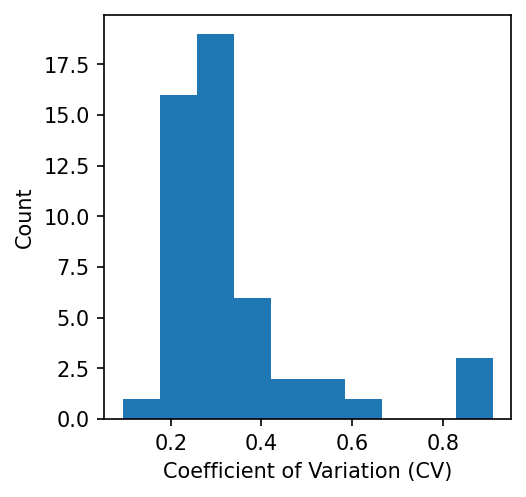

0.340438874649274


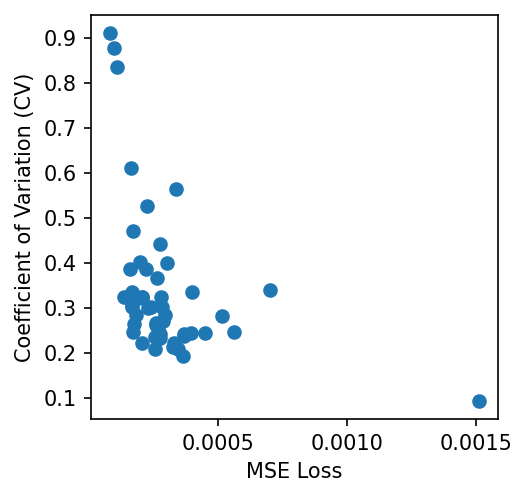

In [75]:
plt.figure(figsize=(3.5, 3.5), dpi=150)
plt.hist(pred_cv)
plt.xlabel("Coefficient of Variation (CV)")
plt.ylabel("Count")
plt.savefig('paper/figs/pred_loss_cv_hist.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print(sum(pred_cv) / len(pred_cv))

plt.figure(figsize=(3.5, 3.5), dpi=150)
plt.scatter(pred_mse, pred_cv)
plt.xlabel("MSE Loss")
plt.ylabel("Coefficient of Variation (CV)")
plt.savefig('paper/figs/pred_loss_cv_v_mse.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
losses = torch.zeros(preds.shape[0] * preds.shape[1] * preds.shape[2])

mle = torch.nn.MSELoss()
mse = mle(preds, actuals).detach().numpy().item()

idx = 0
for ridx in range(preds.shape[0]):
 for tidx in range(preds.shape[1]):
  for cidx in range(preds.shape[2]):
    cur_loss = mle(preds[ridx, tidx, cidx], actuals[ridx, tidx, cidx]).detach().numpy().item()
    losses[idx] = cur_loss
    idx += 1
    
print(mse, torch.std(losses).item())

0.000292216514935717 0.0009513962431810796


In [ ]:
losses = torch.zeros(preds.shape[0] * preds.shape[1] * preds.shape[2])

mle = torch.nn.MSELoss()
mse = mle(preds, actuals).detach().numpy().item()

idx = 0
for ridx in range(preds.shape[0]):
 for tidx in range(preds.shape[1]):
  for cidx in range(preds.shape[2]):
    cur_loss = mle(preds[ridx, tidx, cidx], actuals[ridx, tidx, cidx]).detach().numpy().item()
    losses[idx] = cur_loss
    idx += 1
    
print(mse, torch.std(losses).item())